### Machine Learning for Systems & Control 5SC28 2023-2024

# Exercise set for Lecture 6: Reinforcement Learning Basics

This exercise set focuses on demonstrating tabular Q-learning and exploring its properties. Additionally, it provides guidance on defining an effective observation space and reward function.

## Table of contents

1. <a href="#Exercise-1:-Multi-Armed-Bandit">Exercise 1: Multi-Armed Bandit</a>
2. <a href="#Exercise-2:-Grid-World">Exercise 2: Grid World</a>
3. <a href="#Exercise-3:-Race-Track">Exercise 3: Race Track</a>
4. <a href="#(Optional)-Exercise-4:-State-Discretization-Mountain-Car">(Optional) Exercise 4: State Discretization Mountain Car</a>
5. <a href="#Exercise-5:-Reward-Function-Design-(Dense-vs-Sparse)">Exercise 5: Reward Function Design (Dense vs Sparse)</a>
6. <a href="#(Optional)-Exercise-6:-Multi-Goals-RL">(Optional) Exercise 6: Multi Goals RL</a>

## Exercise 1: Multi-Armed Bandit

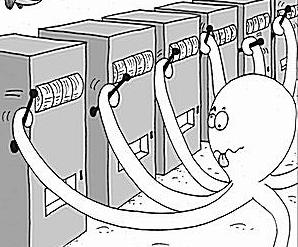

This exercise considers the multi-armed bandit problem (introduced during the lecture). We are playing on a 4 slot machines. At each time instance we can choose to play on one machine only. The slot machines give a reward $r$ which is either equal to $0$ or $1$. The probability that slot machine $i$ gives a reward $r=1$ is denoted by $P_i$. Our goal is to maximize the cumulative reward which is $\sum_{k=1}^{N_{\text{steps}}} r_k$ where $N_{\text{steps}} = 10^3$. 

**a)** Derive the recursive equation discussed in lectures slides. You have to show that:

$$
X_k = \frac{1}{k} \sum_{i=1}^k x_i = X_{k-1} + \frac{1}{k} \left (x_k - X_{k-1} \right )
$$


**Answer a):** $$ X_{k} =\frac{1}{k} \sum_{i=1}^{k} x_{i} $$ $$ =\frac{1}{k}\left(x_{k}+\sum_{i=1}^{k-1} x_{i}\right) $$ $$ =\frac{1}{k}\left(x_{k}+(k-1) X_{k-1}\right) $$ $$ =X_{k-1}+\frac{1}{k}\left(x_{k}-X_{k-1}\right)$$


To implement the multi-armed bandit problem, we'll utilize the gymnasium environments https://gymnasium.farama.org/index.html. This standardizes the environment construction and saves a lot of time in the long run. [Note that gymnasium environment is also one of the available formats of the design assignment environment]. 

By using the framework provided by gymnasium environments we can write algorithms which are applicable to many different environments. You can read the documentation https://gymnasium.farama.org/content/basic_usage/, section "Available Environments" for a quick overview.

**b)** Run the example below and see how it works in this simplified setup. 

*note 1: The environment is set up such that we can input a lambda function to the elements of $P$ which is needed for e)*

*note 2: Both the returned `terminated` and `truncated` variables that are returned in .step indicate whether the environment needs to be reset.  However, there are cases where the environment needs to be reset even when it's not in a terminal state, such as when a time limit is reached. Gymnasium introduces two variables to handle this scenario. For more information see: [docs](https://gymnasium.farama.org/content/migration-guide/#environment-step) and a [Discussion on this fact](https://www.reddit.com/r/reinforcementlearning/comments/bb5mzl/d_confused_about_envis_done/)*

In [1]:
#you might still need to install the gymnasium
#uncomment next statement to install the gymnasium if you get an import error, and if that fails use the anaconda prompt
#!pip install gymnasium
#pip install ufal.pybox2d

In [2]:
!pip install gymnasium[classic-control]
#https://pypi.org/project/ufal.pybox2d/

In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class Multiarmed_bandit(gym.Env):
    def __init__(self, P = [lambda k: 0.5, lambda k: 0.4, lambda k: 0.7, lambda k: 0.6]):
        self.P = P
        self.action_space = spaces.Discrete(len(self.P)) #u = 0, 1, ..., len(P)-1
        self.k = 0
    
    def step(self, u):
        Pnow = self.P[u] #select the uth element
        obs = None
        reward = int(np.random.rand()<Pnow(self.k)) #set reward to 1 if random uniform < P
        terminated = True #terminated = True indicates that there is no memory in the system.
        truncated = False #truncated is set to True if an episode is cut short.
        info = {} 
        self.k += 1
        return obs, reward, terminated, truncated, info
        
env = Multiarmed_bandit()
obs, reward, terminated, truncated, info = env.step(0)
print('reward 1 =',reward)
obs, reward, terminated, truncated, info = env.step(0)
print('reward 2 =',reward)
obs, reward, terminated, truncated, info = env.step(0)
print('reward 3 =',reward)


reward 1 = 1
reward 2 = 0
reward 3 = 0


**c)** Consider the multi-arm bandit problem with the probabilities of $P_1 = 0.5$, $P_2 = 0.4$, $P_3 = 0.7$ and $P_4 = 0.6$. Implement the $\epsilon$-greedy approach with the Q averaging as discribed in **a)**. Apply this function with `epsilon=0.1` on the environment and observe the resulting Q values, plot `Rewards_list`, and thereafter interpret the results.

*tip: if `alpha=None` it indicates to use averaging as in **a)** setup*

*tip: use the `argmax` function provided below which has some additional desired properties over `np.argmax`*

The $\epsilon$-greedy approach is given by 

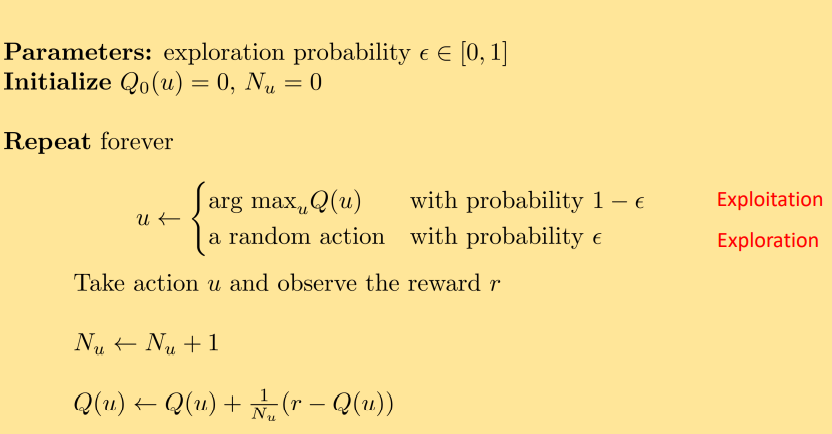

[0.49999999999999994, 0.2571428571428572, 0.6975717439293597, 0.6428571428571431]


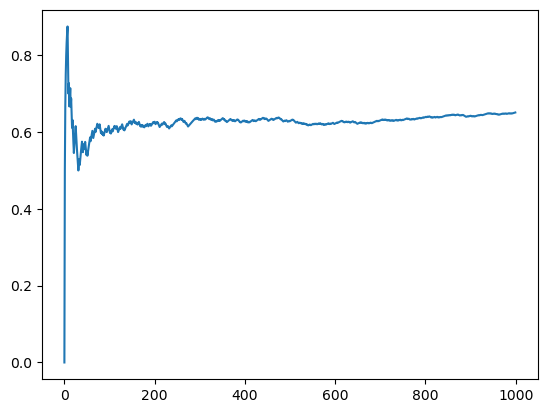

In [4]:
from matplotlib import pyplot as plt

def argmax(a):
    #argmax([0,1,2,3]) -> 3
    #argmax([0,1,2,2]) -> 2 or 3 with equal probability of both (np.argmax would only return 2)
    #argmax([0,0,0,0]) -> 0, 1, 2 or 3 with equal probability of each (np.argmax would only return 0)
    a = np.array(a)
    return np.random.choice(np.arange(a.shape[0],dtype=int)[a==np.max(a)])

def Qlearn_No_Obs(env, epsilon = 0.1, alpha=None, Nsteps = 1000):
    Q = [0.,0.,0.,0.] #c=)
    N = [0,0,0,0] #c=)
    
    #used for plotting later
    Rewards_acc = 0 # accumelated rewards
    Rewards_list = [] # the list of the mean reward obtained up until this point
    
    for k in range(1,Nsteps+1):
        if epsilon<np.random.rand(): #c)
            u = argmax(Q) #c)
        else: #c)
            u = env.action_space.sample() #equivilent to np.random.randint(low=0, high=len(Q)) #c)
        N[u] += 1 #c)
        
        obs, reward, terminated, truncated, info = env.step(u)
        
        TD = (reward - Q[u])#c)
        if alpha is None: 
            Q[u] = Q[u] + 1/N[u]*TD #c)
        else: 
            dummy = 1 #otherwise an error would show if f) is not filled in yet
            Q[u] = Q[u] + alpha*TD #f)
            
        #used for plotting later
        Rewards_acc += reward
        Rewards_list.append(Rewards_acc/k)
    return Q, np.array(Rewards_list)

env = Multiarmed_bandit()
Q, Rewards_list = Qlearn_No_Obs(env, epsilon=0.1, Nsteps=1000) #c)
print(Q) #c)
#Q is close to the values of P. #c)
plt.plot(Rewards_list) #c)
plt.show() #c)
#the rewards improve during trainig #c)



**d)** Explore the impact of different values of $\epsilon$ using the cell below. What happens when $\epsilon$ is set to too low or too high? Can you formulate this in terms of the trade-off between exploration and exploitation?

**Answer d):** When $\epsilon$ is too low, the algorithm becomes excessively greedy, relying heavily on its current knowledge and potentially missing out on better options. On the other hand, when $\epsilon$ is too high, the algorithm focuses too much on exploring new possibilities, making random choices that may not lead to optimal outcomes.

Finding the right balance between exploration and exploitation is critical in reinforcement learning. Adjusting the value of $\epsilon$ allows us to modulate this balance, and examining its effects helps us gain insights into how the algorithm learns and adapts over time.

*tip: `Ntrail`'s are performed for different values of `epsilon` and plot the result of each in the cell below.*

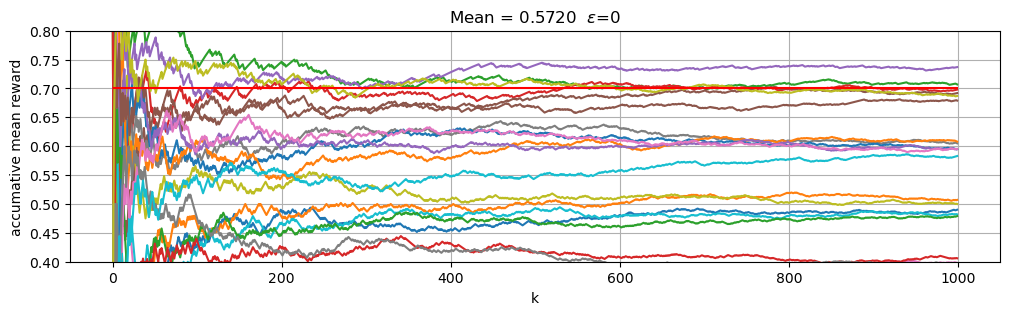

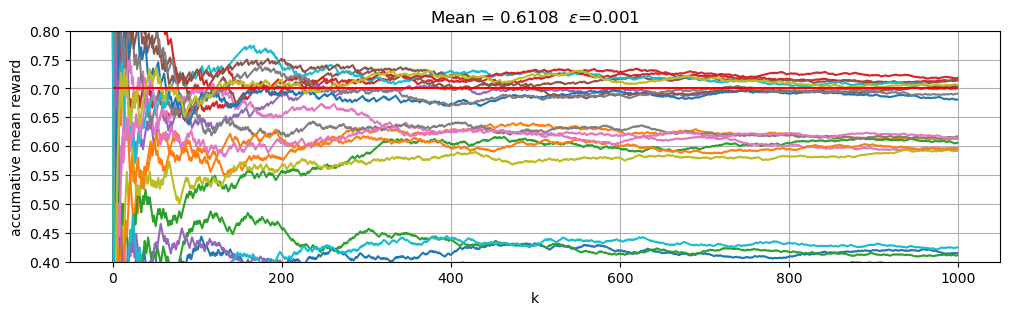

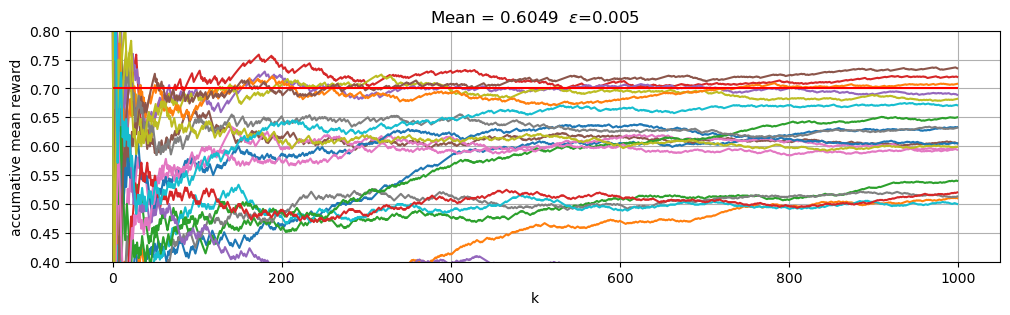

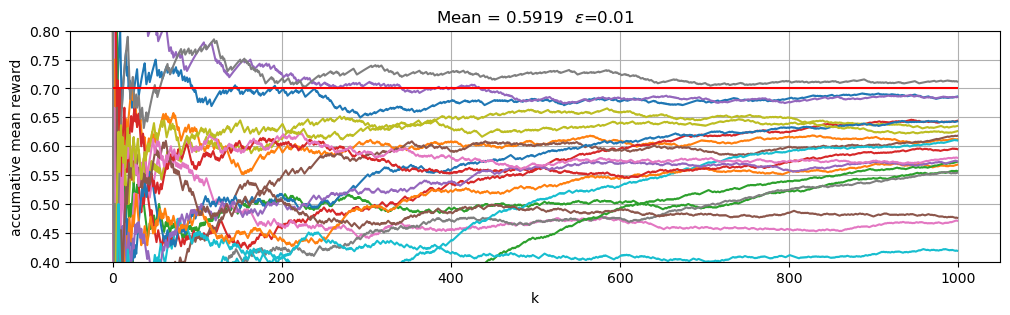

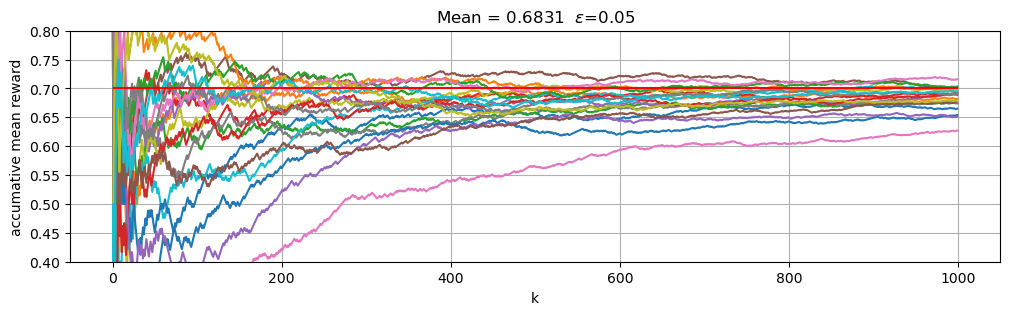

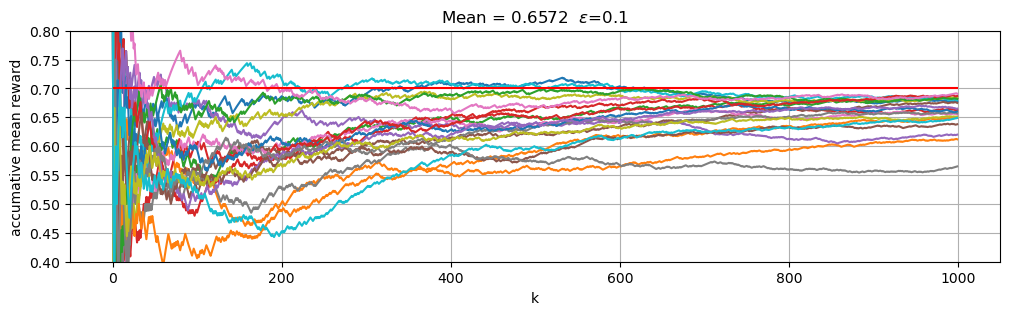

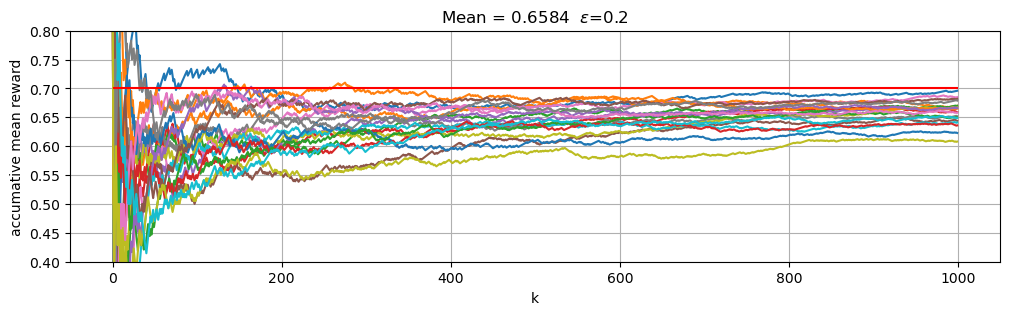

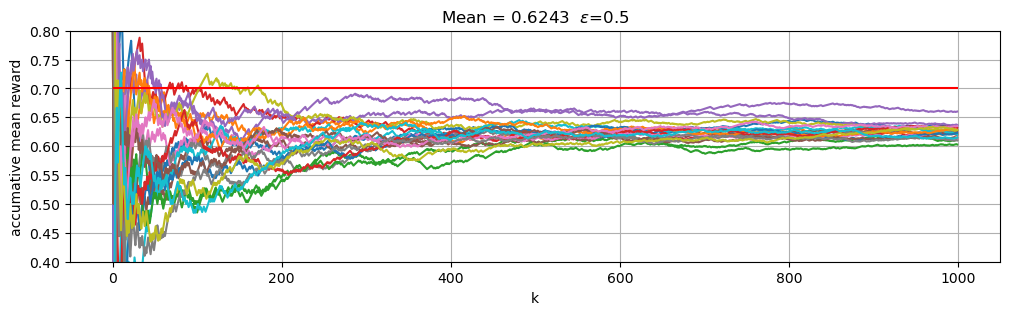

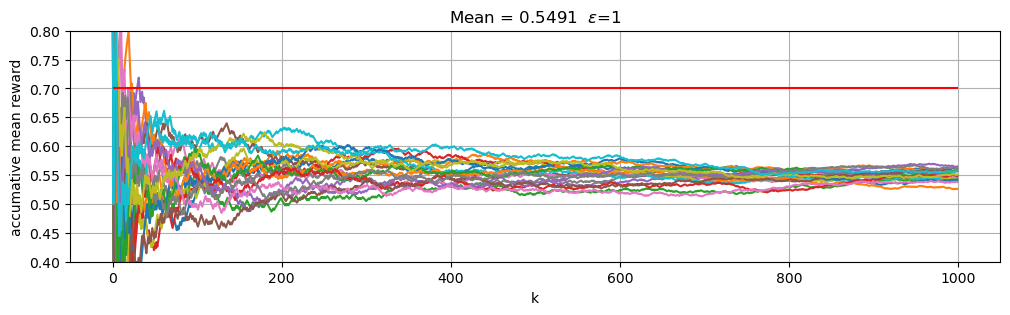

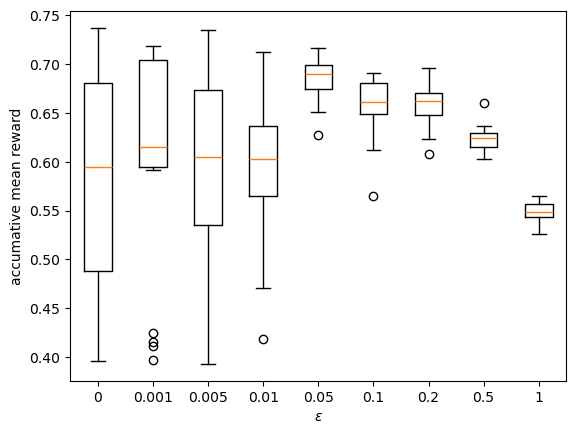

In [5]:
Ntrails = 20
RRewards = []
eps_list = [0,0.001,0.005,0.01,0.05,0.1,0.2,0.5,1]

for epsilon in eps_list:
    Rewards = []
    from matplotlib import pyplot as plt
    plt.figure(figsize=(12,3))
    for k in range(Ntrails):
        
        env = Multiarmed_bandit()
        Q, Rewards_list = Qlearn_No_Obs(env, epsilon=epsilon,Nsteps=1000)
        Rewards.append(Rewards_list[-1])
        plt.plot(Rewards_list)
        
    plt.grid()
    plt.title(fr'Mean = {np.mean(Rewards):.4f}  $\epsilon$={epsilon}')
    plt.hlines(0.7,0,len(Rewards_list),'r')
    plt.ylim(0.4,0.8)
    plt.xlabel('k')
    plt.ylabel('accumative mean reward')
    plt.show()
    
    RRewards.append(Rewards)

plt.boxplot(RRewards,labels=[str(eps) for eps in eps_list])
plt.xlabel(r'$\epsilon$')
plt.ylabel('accumative mean reward')
plt.show()
        
    

**e)** Let's explore a scenario where the probabilities $P_i(k)$ change over time. Why might simply taking the average, as we did previously, not be the best approach in this case?

**Answer e):** When the probabilities change dynamically, relying solely on the average from past steps may not yield optimal results. Older observations may not accurately reflect the current state of the environment, leading to suboptimal decision-making. Therefore, it's essential to give more weight to recent observations, as they provide more relevant information about the current probabilities.

**f)** Update the `Qlearn_No_Obs` function and implement the $\alpha$ update rule as seen in the lecture i.e.

$$
X_k = X_{k-1} + \alpha \underbrace{\left (x_k - X_{k-1} \right )}_{\text{Temporal Difference}}
$$

After implementation, re-run the cell. Then, explain the effects and reasons behind the outcomes when $\alpha$ is set to both low and high values, using the provided cell and plots below.

**Answer f):** When $\alpha$ is too low, the $Q$ values update slowly, making it challenging to adapt to changes in $P_i(k)$. Conversely, if $\alpha$ is too high, the $Q$ values become overly sensitive to noise, leading to poor convergence and inaccurate representations of $P_i(k)$. In this particular example, $\alpha=0.15$ seems to strike a balance, but the optimal value may vary depending on the problem.

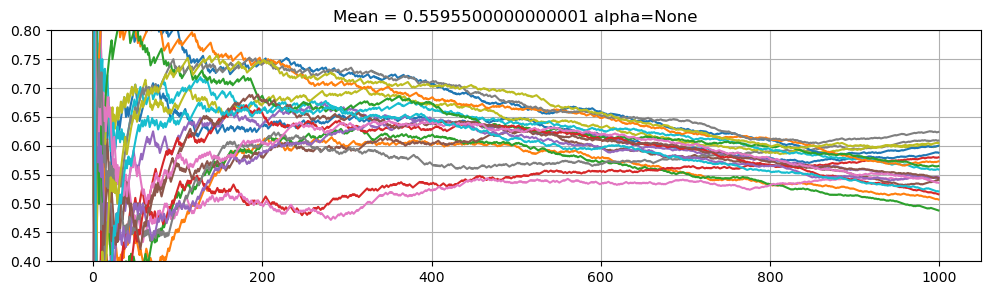

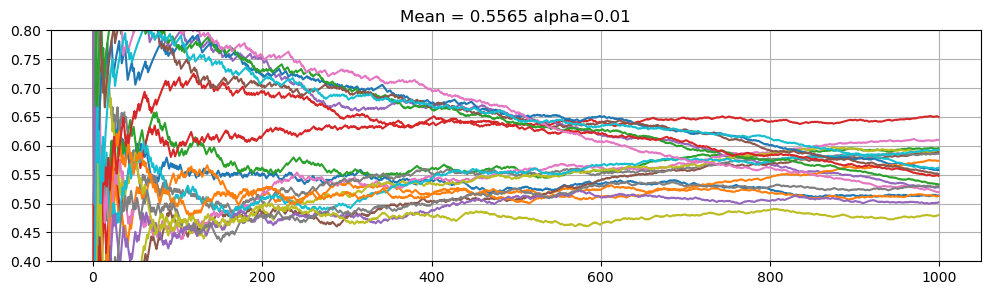

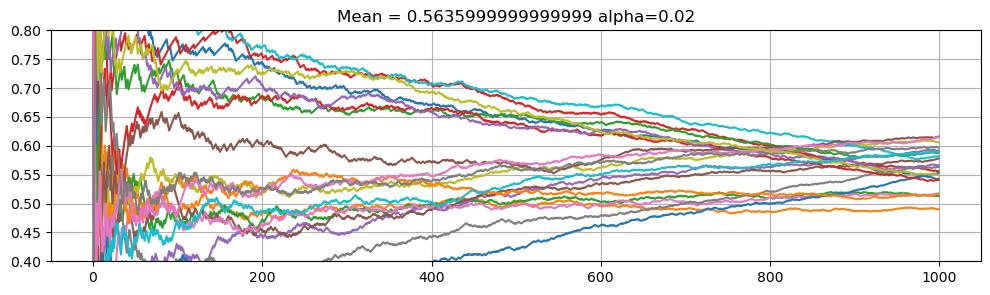

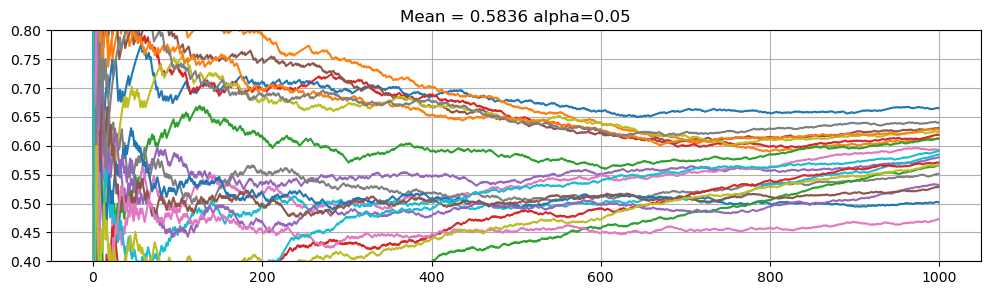

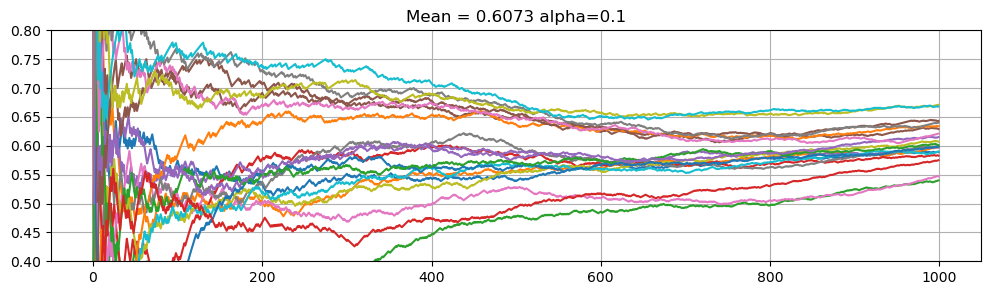

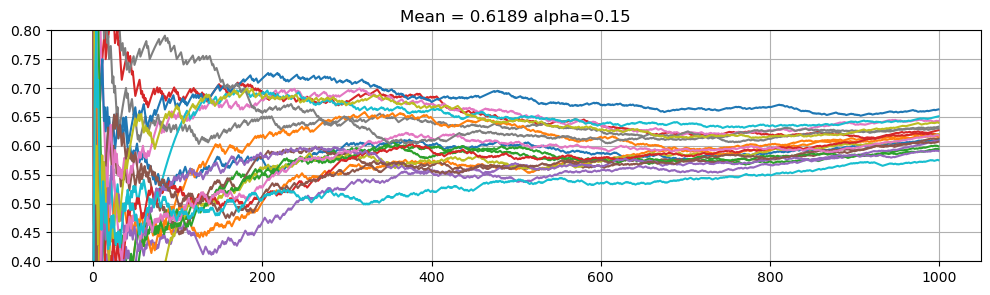

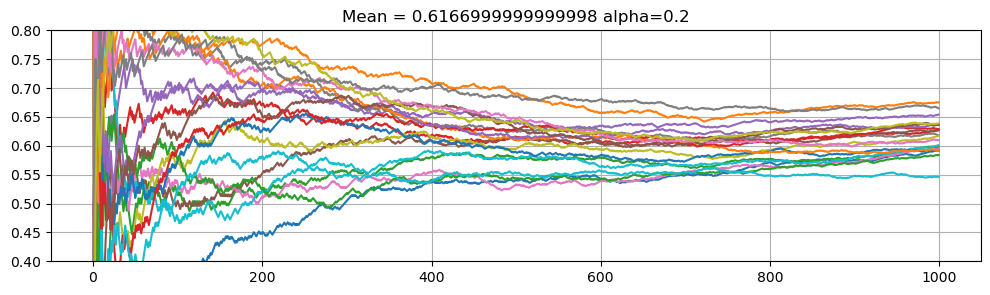

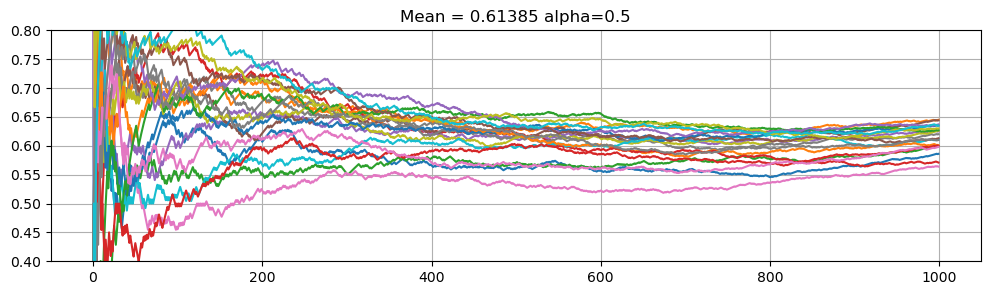

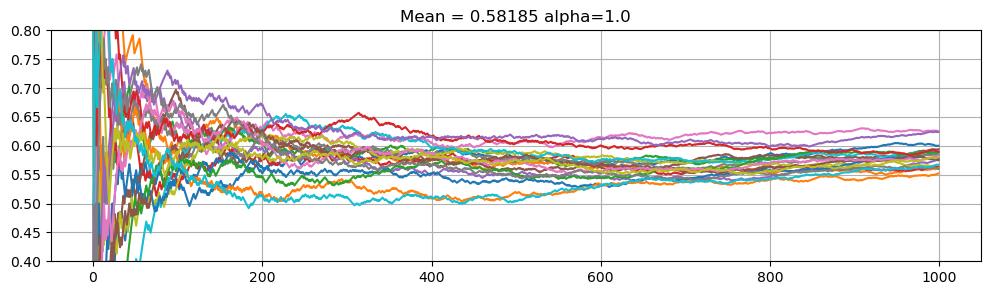

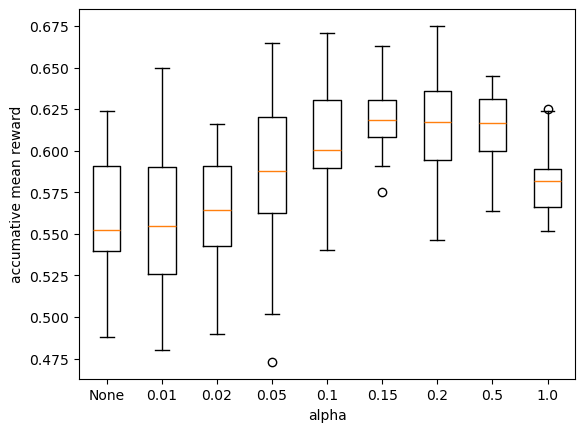

In [6]:
epsilon = 0.1
from matplotlib import pyplot as plt
alpha_list = [None, 0.01,0.02,0.05,0.1,0.15,0.2,0.5, 1.0]
RRewards = []
for alpha in alpha_list:
    Rewards = []
    plt.figure(figsize=(12,3))
    for k in range(20):
        Nsteps = 1000
        P1 = lambda k: 0.5 + 0.2*k/Nsteps
        P2 = lambda k: 0.3 + 0.5*k/Nsteps
        P3 = lambda k: 0.8 - 0.5*k/Nsteps
        P4 = lambda k: 0.5
        env = Multiarmed_bandit(P = [P1, P2, P3, P4])
        Q, Rewards_list = Qlearn_No_Obs(env, epsilon=epsilon, alpha=alpha, Nsteps=Nsteps)
        Rewards.append(Rewards_list[-1])
        plt.plot(Rewards_list)
    plt.grid()
    plt.title(f'Mean = {np.mean(Rewards)} alpha={alpha}')
    plt.ylim(0.4,0.8)
    plt.show()
    RRewards.append(Rewards)
plt.boxplot(RRewards,labels=[str(alpha) for alpha in alpha_list])
plt.xlabel('alpha')
plt.ylabel('accumative mean reward')
plt.show()

## Exercise 2: Grid World

This exercise explores how $Q$-learning can be used to solve a maze called Grid World. The environment is a maze depicted as below:

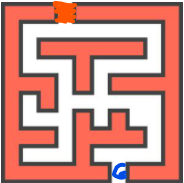

Here are the environment specifics:
* Init: Random starting position
* Goal: Reach the goal (blue G) by moving in all four directions
* Actions: 0 down, 1 right, 2 up, 3 left.
* Rewards/terminal conditions:
 * Walking into a wall gives a reward of -10 and sets terminated=True.
 * Walking into the goal gives a reward of 100 and sets terminated=True.
 * Otherwise reward is 0 and terminated=False.

**Run the cell below** to load the environment. [Feel free to adjust the maze configuration by changing the cell below].

In [7]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class Grid_world(gym.Env):
    
    ######
    # +--------> y (second dim)
    # |
    # |
    # v
    # x (first dim)
    #
    # u=0 -> x+
    # u=1 -> y+
    # u=2 -> x-
    # u=3 -> y-
    def __init__(self):
        
        self.action_space = spaces.Discrete(4) #u = 0, 1, ..., P-1
        self.Goal = 2
        G = self.Goal
        self.Wall = -1
        W = self.Wall
        self.grid = [ #feel free to change the maze
                     [W,W,W,W,W,W,W,W,W,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,W,W,W,W,W,W,0,W],
                     [W,0,0,0,W,0,0,0,0,W],
                     [W,W,W,0,W,0,W,W,W,W],
                     [W,0,W,0,0,0,0,0,0,W],
                     [W,0,0,0,W,0,W,0,0,W],
                     [W,W,W,0,W,W,W,W,0,W],
                     [W,0,0,0,W,0,0,0,0,W],
                     [W,W,W,W,W,W,G,W,W,W],
                    ]
        self.grid = np.array(self.grid,dtype=int)
        self.observation_space = spaces.MultiDiscrete(self.grid.shape)
        self.reset()
        
    
    def reset(self):
        while True:
            self.p = [np.random.randint(low=0,high=self.grid.shape[0]),np.random.randint(low=0,high=self.grid.shape[1])]
            if self.grid[self.p[0],self.p[1]]==0:
                break
        return tuple(self.p), {}
    
    def step(self, u):
        ########
        #  2
        #  ^
        #3<+>1
        #  v
        #  0
        
        if u==0:
            self.p[0] += 1
        elif u==1:
            self.p[1] += 1
        elif u==2:
            self.p[0] -= 1
        elif u==3:
            self.p[1] -= 1
        
        end_loc = self.grid[self.p[0],self.p[1]]
        if end_loc==self.Goal: #goal
            reward = 100
            terminated = True
        elif end_loc==0: #tile
            reward = 0
            terminated = False
        elif end_loc==self.Wall: #wall
            reward = -10
            terminated = True
        truncated = False
        return tuple(self.p), reward, terminated, truncated, {}
    
    def render(self, Qmat=None, mode='human'):
        from collections import defaultdict
        for x in range(self.grid.shape[0]):
            for y in range(self.grid.shape[1]):
                el = self.grid[x,y]
                if el==-1:
                    print('#',end='')
                elif el==2:
                    print('G',end='')
                elif Qmat is None and el==0:
                    if x==self.p[0] and y==self.p[1]:
                        print('P',end='')
                    else:
                        print(' ',end='')
                else:#← ↑ → ↓
                    if isinstance(Qmat,defaultdict):
                        abest = argmax([Qmat[(x,y),a] for a in range(4)])
                    else: #an array
                        abest = argmax(Qmat[x,y,:])
                    print('↓→↑←'[abest],end='')
            print()

**a)** Solve the maze manually by running the cell below and giving inputs (type `down`,`right`,`up` or `left` and enter). Take note of what is returned by env.step. Also, take note of `env.observation_space` and `env.action_space` as you will need that later.

In [8]:
from IPython.display import clear_output
import time
env = Grid_world()
print('observation space =',env.observation_space, env.observation_space.nvec)
print('action space =',env.action_space)
obs, info = env.reset() #reset environment
convert = {'down':0, 'right':1, 'up':2, 'left':3} #to convert from text to input number
terminated = truncated = False
while True:
    env.render() # print the maze
    if terminated:
        if reward==-10:
            print("You Died")
        elif reward==100:
            print('Goal Reached!')
        break
    print('What action do you want to  take? (type up, down, left or right)')
    time.sleep(1/4) # wait a bit
    s = input() # take input from user
    action = convert[s] # convert text to action (0, 1, 2 or 3)
    clear_output(wait=True)
    obs, reward, terminated, truncated, info = env.step(action) #take action
    print('obs=',obs) # observation/measurment/state
    print('reward=',reward) # reward = -10 if you bump into a wall, 100 if you reach to goal and 0 otherwise
    print('terminated=',terminated) # is true if you bump into a wall or solve the maze

obs= (2, 5)
reward= -10
terminated= True
##########
#        #
# ###### #
#   #    #
### # ####
# #      #
#   # #  #
### #### #
#   #    #
######G###
You Died


We saw in the lecture that the $Q$-learning algorithm is given by 

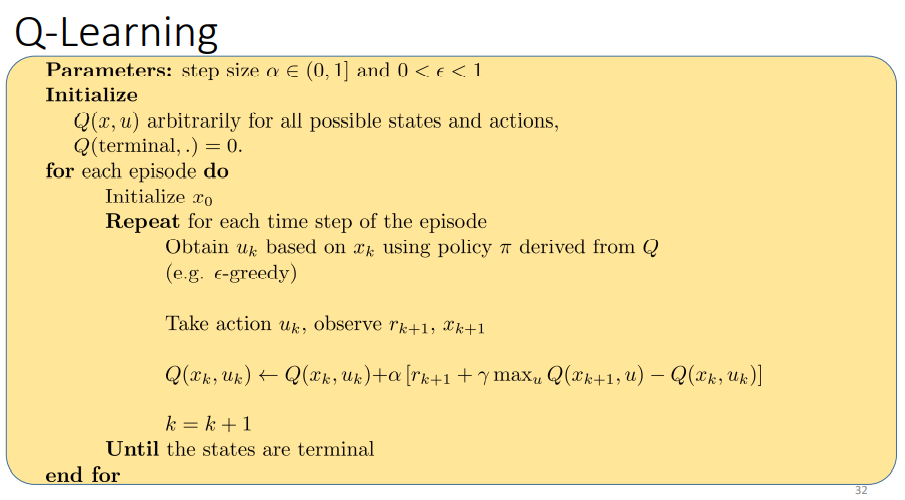

However, there is a problem with implementing this directly as it is often unknown which states are terminal states (i.e. $Q(\text{terminal},.)$). Therefore, we'll use an alternative but equivalent algorithm, which can be expressed as follows:

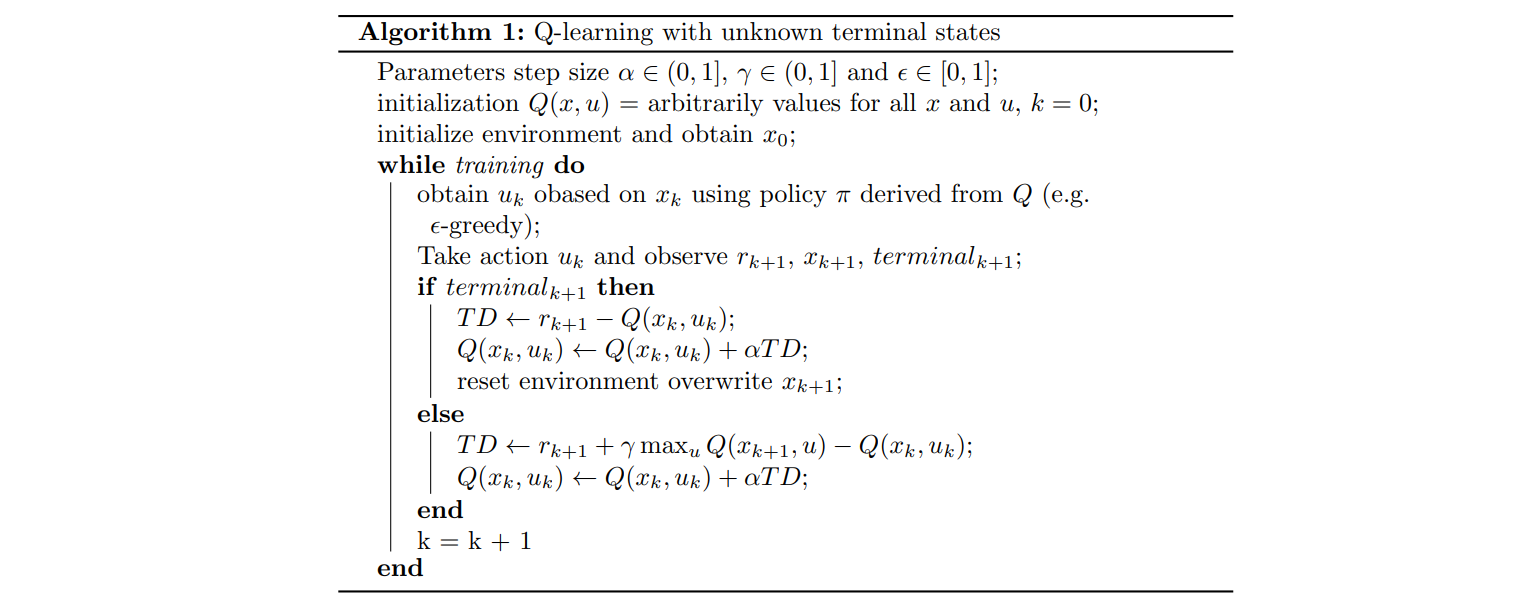

(TD = temporal difference)

**b)** Verify that these two algorithms are mostly the same algorithm. 

**c)** Implement $Q$-learning with $\epsilon$-greedy exploration and a discount factor $\gamma$ to solve the grid world problem. Pay close attention to the required shape of the NumPy array representing $Q(x,u)$ to ensure a successful implementation.

*tip: use env.observation_space.nvec and env.action_space.n*

*tip: What is the range of values that the observations and actions can have?*


In [9]:
def argmax(a):
    #random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a),dtype=int)[a==np.max(a)])

def QlearnGrid(env, alpha=0.1, epsilon=0.1, gamma=1.0, nsteps=10000):
    #init Q:
    Qmat = np.zeros(tuple(env.observation_space.nvec) + (env.action_space.n,)) #b=)
    obs, info = env.reset()
    for z in range(nsteps):

        if np.random.uniform()<epsilon: #b)
            action = env.action_space.sample() #b)
        else: #b)
            action = argmax(Qmat[obs[0],obs[1],:]) #b)
        obs_new, reward, terminated, truncated, _ = env.step(action) #b)

        if terminated:
            TD = reward - Qmat[obs[0],obs[1],action] #b)
            Qmat[obs[0],obs[1],action] += alpha*TD #b)
        else:
            MaxQ = max(Qmat[obs_new[0],obs_new[1],action_next] for action_next in range(env.action_space.n)) #b)
            TD = reward + gamma*MaxQ - Qmat[obs[0],obs[1],action] #b)
            Qmat[obs[0],obs[1],action] += alpha*TD #b)
            obs = obs_new #b)
        if terminated or truncated:
            obs, info = env.reset()
    return Qmat

env = Grid_world()
Qmat = QlearnGrid(env, alpha=0.1, epsilon=0.1, gamma=0.99, nsteps=100_000)
env.render(Qmat)

##########
#↓←←→→→→↓#
#↓######↓#
#→→↓#↓←←←#
###↓#↓####
#↓#→→→→↓←#
#→→↑#↑#→↓#
###↑####↓#
#→→↑#→↓←←#
######G###


For tabular Q-learning there exists quite an elegant and effective solution using `defaultdict`. See [instructions](https://realpython.com/python-defaultdict/) and the example below, (also see [Mutable vs Immutable Objects in Python](https://www.geeksforgeeks.org/mutable-vs-immutable-objects-in-python/))

In [10]:
from collections import defaultdict
Q = defaultdict(lambda: float(0))
print(Q[10,2]) #prints 0 and creates an new element
Q[(10,10),5] += 1
print(Q) #has two values without having explicitly initalized them
# Q[[10,10],5] #This is not allowed, no lists or arrays allowed as arguments, tuples are ok
             #It only allows for Immutable Objects see link above
             # use Q[tuple([10,10]),5] instead


0.0
defaultdict(<function <lambda> at 0x000001D459EA4670>, {(10, 2): 0.0, ((10, 10), 5): 1.0})


This approach is highly desirable as it can accommodate observation spaces and action spaces of any size. Additionally, it dynamically creates elements that are actually reachable, thereby saving memory, especially in larger problems. Refer to the example below for implementation details.

In [11]:
from collections import defaultdict
def Qlearn(env, alpha=0.1, epsilon=0.1, gamma=1.0, nsteps=10000):
    Qmat = defaultdict(lambda: float(0)) #any new argument be set to zero
    obs, info = env.reset()
    for z in range(nsteps):
        if np.random.uniform()<epsilon:
            action = env.action_space.sample()
        else:
            action = argmax([Qmat[obs,a] for a in range(env.action_space.n)])

        obs_new, reward, terminated, truncated, _ = env.step(action)

        if terminated:
            TD = reward - Qmat[obs,action]
            Qmat[obs,action] += alpha*TD
        else:
            Qmax = max(Qmat[obs_new, action_next] for action_next in range(env.action_space.n))
            TD = reward + gamma*Qmax - Qmat[obs,action]
            Qmat[obs,action] += alpha*TD
            obs = obs_new
        if terminated or truncated:
            obs, info = env.reset()
    return Qmat

env = Grid_world()
obs, info = env.reset()
Qmat = Qlearn(env, alpha=0.1, epsilon=0.1, gamma=0.99, nsteps=10_000)
env.render(Qmat)
print(len(Qmat))

##########
#↓←←←→→→↓#
#↓######↓#
#→→↓#↓←←←#
###↓#↓####
#↓#→→→→→↓#
#→→↑#↑#→↓#
###↑####↓#
#→→↑#→↓←←#
######G###
164


## Exercise 3: Race Track

In this exercise, we'll apply $Q$-learning to a more complex environment: a race track!

Below is an illustration showing the trajectory of a trained Q-learning agent on this track:

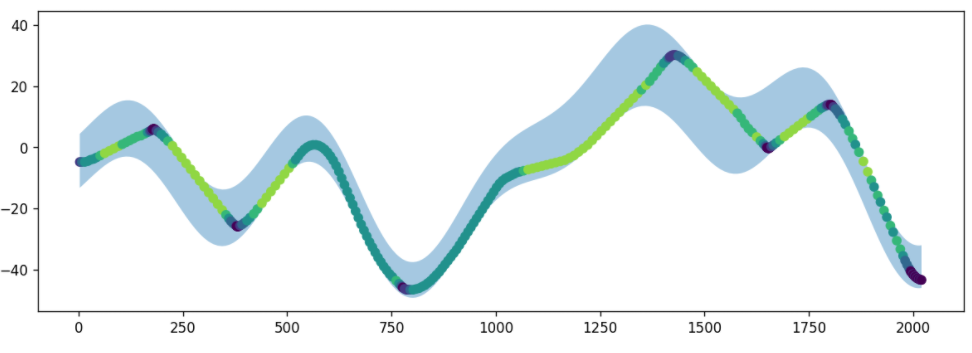

Additionally, here's how the sensors are positioned on the track:

* Green represents the car's position
* Blue indicates active sensors
* Red denotes inactive sensors

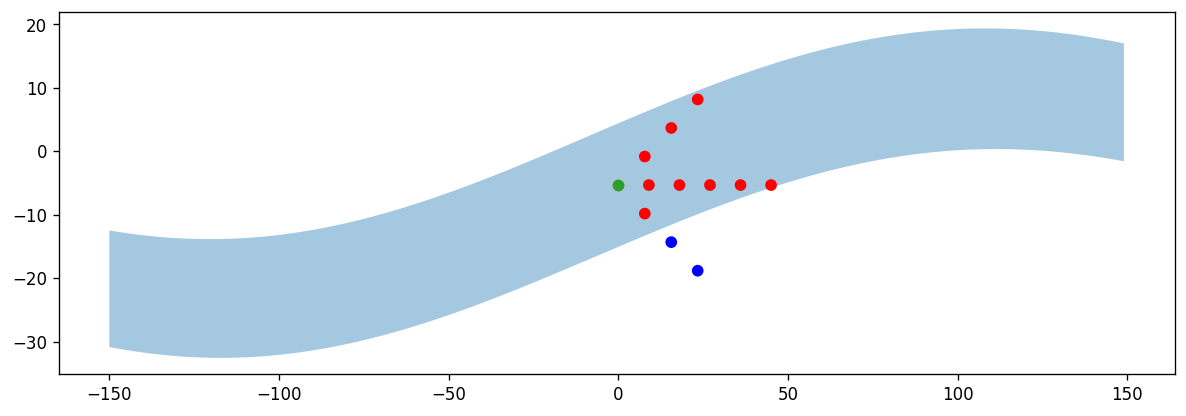

Here's a breakdown of the environment:

* Track: 
  * Random phase multisine with constant width
* Actions: (5)
  * 0 turn left
  * 1 turn right
  * 2 do nothing
  * 3 speed up
  * 4 slow down
* Observation: (7,4,6,4)
  * Velocity: 7 values
  * Sensors: 3 Arrays of sensors as seen in the figure above  (1 more than the number of sensors)
    * 3 sensores pointed left 
    * 5 pointed straight
    * 3 sensores pointed right (state from above picture would be (0,3,5,1) = (speed,left, straight, right))
* Reward/terminal state:
  * Off track: 
    * reward = -1000 and terminated=True
  * On track:
    * reward = horizontal speed and terminated=False

**Run the cell below**

(0, 1, 3, 3)


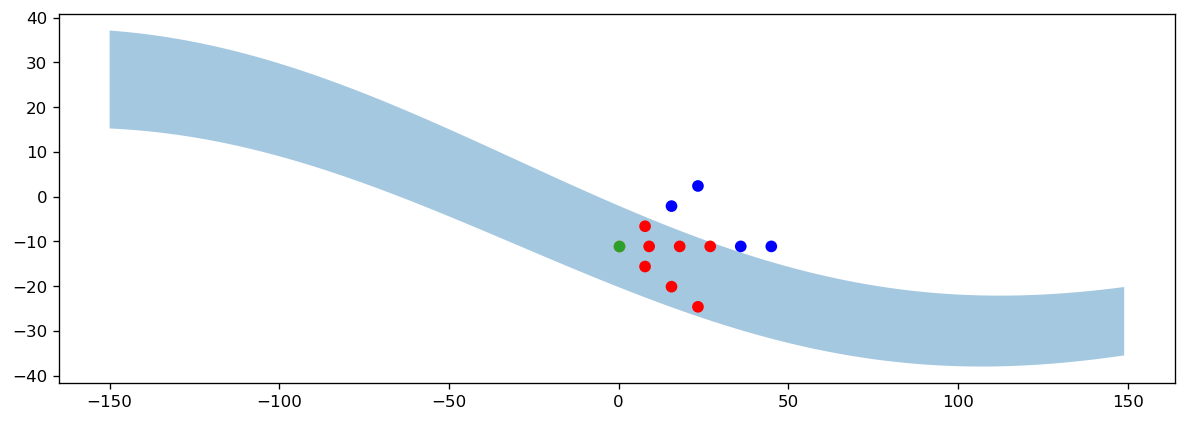

In [12]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
class race_track(gym.Env):
    def __init__(self):
        #obs =  [car.speed, car.s(1).value, car.s(2).value, car.s(3).value];
        self.observation_space = spaces.MultiDiscrete((7,4,6,4))
        self.action_space = spaces.Discrete(5)
        self.sensordist = 9
        self.maxspeed = 6
        self.vStep = 2
        self.hStep = 2
        #0 Turn left
        #1 Turn Right
        #2 Do nothing
        #3 Slow down
        #4 speedup
#     car.s(1).heading = 30;
#     car.s(1).distance = 9;
#     car.s(1).nDistances = 3;
#     car.s(2).heading = 0;
#     car.s(2).distance = 9;
#     car.s(2).nDistances = 5;
#     car.s(3).heading = -30;
#     car.s(3).distance = 9;
#     car.s(3).nDistances = 3;
        self.reset()

    def step(self,action):
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        if action==0:
            self.heading += self.hStep
        elif action==1:
            self.heading -= self.hStep
        elif action==2:
            pass
        elif action==3: #slow down
            self.speed = self.speed - 1 if self.speed>0 else 0
        elif action==4: #speed up
            self.speed = self.speed + 1 if self.speed<self.maxspeed else self.speed
        
        real_speed = self.speed*self.vStep + 1
        self.x = (self.x + np.cos(self.heading/180*np.pi)*real_speed)%self.tracklength
        self.y = self.y + np.sin(self.heading/180*np.pi)*real_speed;
#         print((self.track(self.x)+self.width(self.x)<self.y) , (self.track(self.x)-self.width(self.x)>self.y))
        if (self.track(self.x)+self.width(self.x)<self.y) or (self.track(self.x)-self.width(self.x)>self.y):
            self.terminated = True
            reward = -1000
        else:
            self.terminated = False
            reward = np.cos(self.heading/180*np.pi)*(real_speed - 1)
        return self.get_state(), reward, self.terminated, False, {}

    def reset(self):
        self.phase = np.random.uniform(size=6)*2*np.pi; #% random shape
        self.tracklength = 4096       #% track length
        f0 = 2*np.pi/self.tracklength    #% base frequency for track generation
        self.track = lambda x: 10*(np.sin(f0*x + self.phase[0]) + np.sin(2*f0*x + self.phase[1]) + \
                         np.sin(3*f0*x + self.phase[2]) + np.sin(4*f0*x + self.phase[3]) + \
                         np.sin(7*f0*x + self.phase[4]) + np.sin(10*f0*x + self.phase[5]))
        self.width = lambda x: 10 + 1.5*(np.sin(f0*x + self.phase[0]) + np.sin(2*f0*x + self.phase[1]) + \
                                         np.sin(3*f0*x + self.phase[2]) + np.sin(4*f0*x + self.phase[3])) #periodic strack
        self.x = 0
        self.y = self.track(self.x)
        self.heading = 0
        self.speed = 0
        return self.get_state(), {}

    def get_state(self):
        state = [self.speed]
        for sensor_angle, nsensors in [(30,3), (0,5), (-30,3)]:
            for k in range(1, nsensors+1): #1,2,3
                posx = self.x + np.cos((self.heading+sensor_angle)/180*np.pi)*self.sensordist*k
                posy = self.y + np.sin((self.heading+sensor_angle)/180*np.pi)*self.sensordist*k
                intrack = self.track(posx)-self.width(posx) < posy < self.track(posx)+self.width(posx)
                if not intrack:
                    break
            else: #only runs when the for loop didn't break
                k = nsensors+1
            k -= 1 #0 = all sensors outside of track, 1 = one sensor out of track
            state.append(k)
        return tuple(state)
    
    def seed(self,seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def render(self, mode='human', close=False):
        from matplotlib import pyplot as plt
#         x = np.arange(self.tracklength)
        x = np.arange(self.x-150,self.x+150)
        track = self.track(x)
        width = self.width(x)
        plt.figure(figsize=(12,4),dpi=120)
        plt.fill_between(x,track-width,track+width,alpha=0.4)
        plt.scatter([self.x],[self.y])
        sensx = []
        sensy = []
        colours = []
        for sensor_angle, nsensors in [(30,3), (0,5), (-30,3)]:
            for k in range(1, nsensors+1): #1,2,3
                posx = self.x + np.cos((self.heading+sensor_angle)/180*np.pi)*self.sensordist*k
                posy = self.y + np.sin((self.heading+sensor_angle)/180*np.pi)*self.sensordist*k
                sensx.append(posx)
                sensy.append(posy)
                intrack = self.track(posx)-self.width(posx) < posy < self.track(posx)+self.width(posx)
                colours.append('r' if intrack else 'b')
                
        plt.scatter([self.x],[self.y])
        plt.scatter(sensx,sensy,c=colours)
        plt.show()

from matplotlib import pyplot as plt
import matplotlib

def traject(Qmat):
    env = race_track()
    obs, info = env.reset()
    xar = []
    yar = []
    speedar = []
    actar = []
    for i in range(300):
        action = argmax([Qmat[obs,act] for act in range(env.action_space.n)])
        actar.append(action)
        obs, reward, terminated, truncated, _ = env.step(action)
        xar.append(env.x)
        yar.append(env.y)
        speedar.append(env.speed)
        if terminated:
            break
    return [np.array(a) for a in [xar, yar, speedar, actar]]+[env]

def visualize_traject(Qmat):
    xar, yar, speedar, actar, env = traject(Qmat)

    track = env.track(xar)
    width = env.width(xar)
    plt.figure(figsize=(12,4),dpi=120)
    plt.fill_between(xar,track-width,track+width,alpha=0.4)
    plt.title(f'Average horizontal speed = {xar[-1]/300}')
    
    plt.scatter(xar,yar,color=matplotlib.colormaps['viridis'](np.array(speedar)/6))
    plt.show()
        
env = race_track()
print(env.reset()[0])
env.render()

 We have already set up the implementation of $Q$-learning on this problem (`Qlearn` function). This implementation saves the past obtained rewards in a rolling average called `reward_rolling` and saves this rolling average in a list of `reward_rolling_hist` each `callbackfeq` steps. 
 
**a)** Apply the `Qlearn` function to the race car environment and plot the resulting reward history. Also, use the `visualize_traject` function to show the trajectory which is obtained using `Qmat`. Lastly, manually change the hyperparameters to find an optimum and good performance.

*tip: the Qlearn function takes in the environment construction `env_con` as we need that in the next exercise, use as `Qlearn(race_track,...)`*

You might notice that the optimization process is not entirely smooth or monotonically increasing. This can lead to suboptimal results if the optimization stops at one of the performance dips. Such issues become more critical when transitioning to Deep Reinforcement Learning in the next lecture. One practical solution is to implement a callback function that checks whether the current `Qmat` is better or worse than the current best-known `Qmat` using a deterministic test ($\epsilon=0$).

**b)** Write the test function which calculates the mean accumulated rewards on a given `Qmat` and saves a copy of it as a global variable `Qbest` if a new best-known performance is obtained.

*tip: to copy Qmat use the deepcopy function `from copy import deepcopy`.*

*tip: do not use $\epsilon$ greed in the test function*



In [ ]:
def Qlearn(env_con, nsteps=50_000, callbackfeq=1000, alpha=0.2, eps=0.2, gamma=0.99, callback=None):
    from collections import defaultdict
    Qmat = defaultdict(float) #any new argument be set to zero
    reward_rolling = -20
    reward_rolling_alpha = 1/500
    reward_rolling_hist = []
    
    env = env_con()
    obs, info = env.reset()
    for z in range(nsteps):

        if np.random.uniform()<eps:
            action = env.action_space.sample()
        else:
            action = argmax([Qmat[obs,a] for a in range(env.action_space.n)])

        obs_new, reward, terminated, truncated, _ = env.step(action)

        if terminated:
            A = reward - Qmat[obs,action] #adventage
            Qmat[obs,action] += alpha*A
        else:
            A = reward + gamma*max(Qmat[obs_new, action_next] for action_next in range(env.action_space.n)) - Qmat[obs,action]
            Qmat[obs,action] += alpha*A
            obs = obs_new
        if terminated or truncated:
            obs, info = env.reset()
        
        #callback and 
        reward_rolling = reward_rolling*(1-reward_rolling_alpha) + reward*reward_rolling_alpha
        if z%callbackfeq==0:
            reward_rolling_hist.append(reward_rolling)
            print('Rolling average at', z, 'has', reward_rolling)
        
        if callback and z%callbackfeq==0:
            callback(Qmat,z,env_con)
    return Qmat, np.array(reward_rolling_hist)


best_rewards = -float('inf') #needed for b) #best known test result
Qbest = None #needed for b)
def test(Qmat,z,env_con):
    global best_rewards, Qbest
    env = env_con() #make a new test environment
    obs, info = env.reset() #b)
    rewards = 0 #b)
    Nsteps = 1000 #b)
    for k in range(Nsteps): #b)
        action = argmax([Qmat[obs,act] for act in range(env.action_space.n)]) #b)
        obs, reward, terminated, truncated, _ = env.step(action) #b)
        if terminated or truncated: #b)
            obs, info = env.reset() #b)
        rewards += reward #b)
    rewards /= Nsteps #b)
    if rewards>best_rewards: #b)
        from copy import deepcopy #b)
        best = rewards #b)
        Qbest = deepcopy(Qmat) #b)
    print(f'Test result: step {z}', rewards) #b)
    return None
        

Qmat, rewards_hist = Qlearn(race_track, nsteps=500_000, callbackfeq=5000, eps=0.05, alpha=0.1, callback=test) #a)
plt.plot(rewards_hist) #a)
plt.show() #a)
np.random.seed(42) #a)
visualize_traject(Qmat) #a)
np.random.seed(42) #a)
visualize_traject(Qbest) #b)

Rolling average at 0 has -19.96
Test result: step 0 -27.292752812658648
Rolling average at 5000 has -20.84717128565481
Test result: step 5000 -7.931329760027298
Rolling average at 10000 has -8.337913526768196
Test result: step 10000 -8.370143747258131
Rolling average at 15000 has -7.312429554802523
Test result: step 15000 -3.8602583809395803
Rolling average at 20000 has -3.779454969345093
Test result: step 20000 1.796099370466849
Rolling average at 25000 has -2.477292681181323
Test result: step 25000 0.014010677707435923
Rolling average at 30000 has -3.9510643369455813
Test result: step 30000 0.21618191197907136
Rolling average at 35000 has -2.5416802106922334
Test result: step 35000 1.0093575223267612
Rolling average at 40000 has -3.9760645387770497
Test result: step 40000 2.0285583393981983
Rolling average at 45000 has -7.53073921499938
Test result: step 45000 0.38701805057040833
Rolling average at 50000 has -1.1308885766814105
Test result: step 50000 -0.8853137444886229
Rolling aver

Here the difference between the performance of the last obtained $Q$-matrix and the $Q$-matrix which had the highest performance is not too large. However, this difference is expected to grow if one starts to use deep RL, in that case saving the results for the highest performance is essential.

## (Optional) Exercise 4: State Discretization Mountain Car

Up until now, you have only worked with discrete states, however, many control problems have continuous state and action spaces.

An example of an environment with a continuous state is the [Mountain Car problem](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

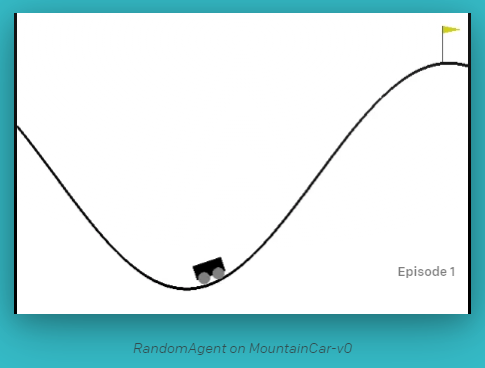

> A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

**Run the cell below** and observe that the observation space is continuous and cannot be captured in a simple look-up table

In case you see error during running the following, you can install [pyglet](https://pypi.org/project/pyglet/)



In [ ]:
import time
import gymnasium as gym
import gymnasium.envs.classic_control
from gymnasium import spaces
import numpy as np
env = gym.envs.classic_control.MountainCarEnv(render_mode='human')
env = gym.wrappers.TimeLimit(env, max_episode_steps=300)
print('action_space = ',env.action_space) # 3 actions
print('observation_space = ',env.observation_space) # a box hence continous observation/state
obs, info = env.reset()
print('obs =', obs)
try:
    env.render()
    terminated = truncated = False
    while terminated == False and truncated == False: #runs for 300 steps due to the TimeLimit Wrapper
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        env.render()
        time.sleep(1/60)
finally:
    env.close()

In the example above we used a wrapper to have the environment return `truncated=True` if 300 steps have been taken. Wrappers are quite an elegant way to modify elements like; inputs, outputs, terminals, tructations, reward functions and more of an environment. This exercise uses wrappers to discretize the state.

For instance, consider the following wrapper, which retains past outputs. This is particularly useful for environments that are not fully observable (e.g., if only the position is measured but speed is also crucial for control).

In [ ]:
from gymnasium import Wrapper
from collections import deque #a list with a fixed lenght
class histwrapper(Wrapper):
    def __init__(self, env, Nhist=7):
        super(histwrapper, self).__init__(env) #sets self.env
        
        shape = env.observation_space.shape #load the obs shape
        shapehist = (Nhist,) + shape #add (Nhist)
        h = env.observation_space.high*np.ones(shapehist) #the upperbounds
        l = env.observation_space.low*np.ones(shapehist) #the lowerbounds
        self.observation_space = spaces.Box(low=l.astype(np.float32),high=h.astype(np.float32)) #modify the observation_space
        self.hist = deque([],Nhist)
        self.Nhist = Nhist
        
    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        self.hist.append(observation)
        observation = np.array(self.hist)
        return observation, reward, terminated, truncated, info

    def reset(self):
        observation, info = self.env.reset()
        self.hist.extend([observation]*self.Nhist)
        print(self.hist)
        observation = np.array(self.hist)
        return observation, info
env = gym.envs.classic_control.MountainCarEnv()

env = histwrapper(env, Nhist=4) #wrap the enviroment with the histwrapper
env.reset()
print(env.step(0))
print(env.step(0))

**a)** Derive an equation to discretize the state $x$ into $x_d$, given upper bound $h$, lower bound $l$, and splitting into $n$ equal-sized sections. For example, consider the figure below, where $x$ falls in the interval corresponding to $x_d=2$.

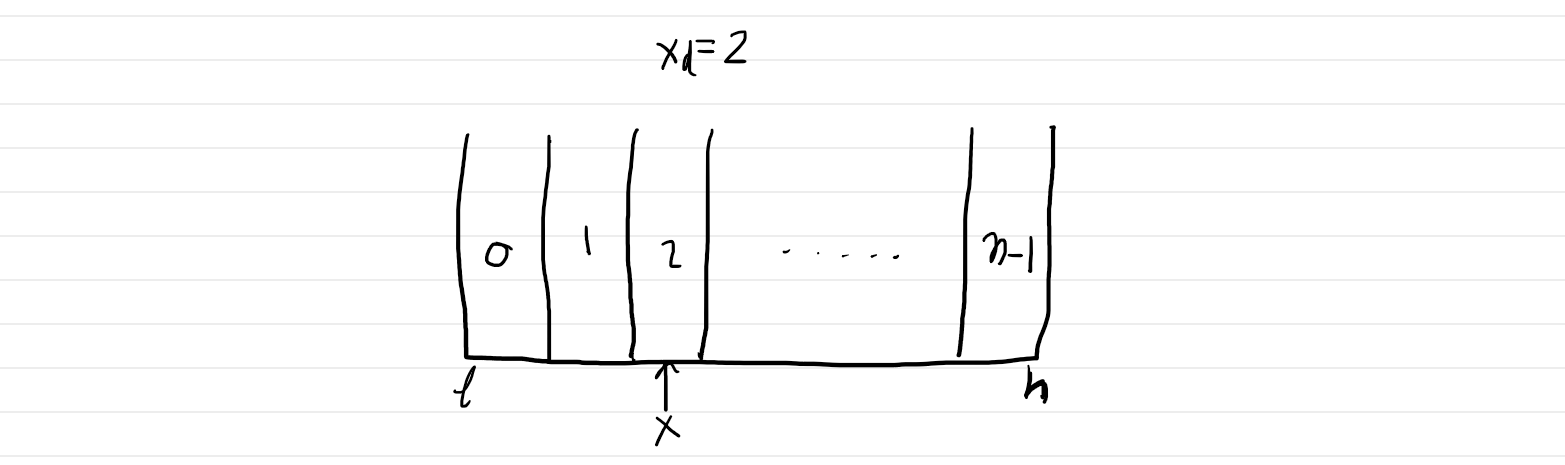

**Answer a):** Here, $\frac{x-l}{h-l}$ scales $x$ to a value between $0$ and $1$, and multiplying by $n$ results in a value between $0$ and $n$, which is then floored to obtain the desired function.


**b)** Write a wrapper that can discretize the state according to the vector $n$ in each dimension. 

*tip: do not forget to discretize the output of the reset function*

*tip: do not forget to change self.observation_space to a `MultiDiscrete` space*

*tip: convert the discretized state to a tuple to be able to use it in `defaultdict` approach*

In [ ]:
class Discretize_obs(gym.Wrapper):
    def __init__(self, env, nvec=10):
        super(Discretize_obs, self).__init__(env) #sets self.env
        if isinstance(nvec,int): #nvec in each dimention
            self.nvec = [nvec]*np.prod(env.observation_space.shape,dtype=int)
        else:
            self.nvec = nvec
        self.nvec = np.array(nvec) #(Nobs,) array
        
        self.observation_space = gym.spaces.MultiDiscrete(self.nvec) #b)
        self.olow, self.ohigh = env.observation_space.low, env.observation_space.high #b)

    def discretize(self,observation): #b)
        return tuple(((observation - self.olow)/(self.ohigh - self.olow)*self.nvec).astype(int)) #b)
        
    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action) #b)
        return self.discretize(observation), reward, terminated, truncated, info #b)

    def reset(self):
        obs, info = self.env.reset()
        obs_dis = self.discretize(obs)  #b=)
        return obs_dis, info

env = gym.envs.classic_control.MountainCarEnv()
env = Discretize_obs(env,nvec=100)
env.reset()
print(env.step(0)) #testing
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(2))
print(env.step(2))
print(env.step(2))

**c)** Use your `Discretize_obs` wrapper to learn a policy for the mountain car problem. Analyze how a large and small discretization factor affects the optimization speed and final performance, and determine the optimal discretization factor for this problem.

**Answer c):** A small discretization factor may not provide sufficient information for effective action selection. Conversely, a large discretization factor results in a higher number of states to optimize, leading to slower optimization. The optimal discretization factor falls between 10 and 20, depending on the desired optimization time.

*tip: make a for loop for multiple nvec and plot the results together*

In [ ]:
def roll_mean(ar,start=2000,N=50): #smoothing if needed
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out

def argmax(a):
    #random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a),dtype=int)[a==np.max(a)])
from matplotlib import pyplot as plt

def Qlearn(env, nsteps=5000, callbackfeq=100, alpha=0.2,eps=0.2, gamma=0.99):
    from collections import defaultdict
    Qmat = defaultdict(float) #any new argument set to zero
    env_time = env
    while not isinstance(env_time,gym.wrappers.time_limit.TimeLimit):
        env_time = env_time.env
    ep_lengths = []
    ep_lengths_steps = []
    
    obs, info = env.reset()
    print('goal reached time:')
    for z in range(nsteps):

        if np.random.uniform()<eps:
            action = env.action_space.sample()
        else:
            action = argmax([Qmat[obs,i] for i in range(env.action_space.n)])

        obs_new, reward, terminated, truncated, info = env.step(action)

        if terminated: #terminal state and not by timeout
            #saving results:
            print(env_time._elapsed_steps, end=' ')
            ep_lengths.append(env_time._elapsed_steps)
            ep_lengths_steps.append(z)
            
            #updating Qmat:
            A = reward - Qmat[obs,action] # adventage or TD
            Qmat[obs,action] += alpha*A
            obs, info = env.reset()
        else: #not terminal
            A = reward + gamma*max(Qmat[obs_new, action_next] for action_next in range(env.action_space.n)) - Qmat[obs,action]
            Qmat[obs,action] += alpha*A
            obs = obs_new
            
            if truncated: #terminal by truncation with timeout
                #saving results:
                ep_lengths.append(env_time._elapsed_steps)
                ep_lengths_steps.append(z)
                print('out', end=' ')
                
                #reset:
                obs, info = env.reset()
    print()
    
    return Qmat, np.array(ep_lengths_steps), np.array(ep_lengths)


Qmats = {}
for nvec in [5,10,20,40,80]: #c)
    max_episode_steps = 1000 #c)
    env = gym.envs.classic_control.MountainCarEnv() #c)
    env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) #c)
    env = Discretize_obs(env,nvec=nvec) #c)

    print('nvec=',nvec) #c)
    Qmat, ep_lengths_steps, ep_lengths = Qlearn(env, nsteps=400_000, callbackfeq=5000) #c=)
    plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=max_episode_steps),label=str(nvec)) #c)
    Qmats[nvec] = Qmat #save
plt.legend() #c)
plt.show() #c)

A simple render block:

In [ ]:
nvec = 20
env = gym.envs.classic_control.MountainCarEnv(render_mode='human') 
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) 
env = Discretize_obs(env,nvec=nvec)
Qmat = Qmats[nvec]

obs, info = env.reset()
try:
    env.render()
    truncated = terminated = False
    while truncated==False and terminated==False:
        action = argmax([Qmat[obs,i] for i in range(env.action_space.n)])
        obs, reward, truncated, terminated, info = env.step(action)
        env.render()
        time.sleep(1/60)
        print(obs,reward,action,truncated, terminated, info) #check info on timelimit
finally:
    env.close()

**d)** Why is it computationally almost impossible to use state discretization when the number of continuous-variable states is equal to 20?

**Answer d):** We observed that an ideal resolution demands approximately 10 discrete states per variable. Consequently, employing this approach for 20 variables would entail managing a total of $10^{20}$ discrete states, rendering it computationally impractical.

The upcoming exercise set will introduce strategies to address this challenge.

## Exercise 5: Reward Function Design (Dense vs Sparse)

In this exercise, we introduce a new environment that resembles the grid world, but with a twist: the objective now is to push a boulder into the goal.

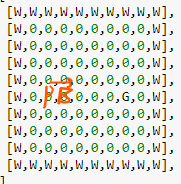

* Environment: 
  * Boulder (B) is pushed when the player moves (P) into it, with as the goal to push the boulder into the Goal (G)
  * Player starts in a random position and the boulder and goal are always start in the same place.
* Action: 0 to 3 (Four cardinal directions)
* Obs:
  * (player x, player y, bolder x, bolder y)
* Reward/Terminal:
  * Moving into a wall: Reward = -1, terminal = False
  * Moving the boulder on the goal: Reward = 1000, terminal = True
  * Otherwise: Reward = 0, terminal = False

You can also find a Q-learn function provided with it which returns a rolling mean episode length (how long it takes for the agent to push the boulder in the goal). It also includes some code for early stopping.

In [ ]:
def argmax(a):
    #random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a),dtype=int)[a==np.max(a)])
import gymnasium as gym
from gymnasium import spaces
from gymnasium import wrappers
import numpy as np
class Grid_world_boulder(gym.Env):
    
    ######
    # +--------> y (second dim)
    # |
    # |
    # v
    # x (first dim)
    #
    # u=0 -> x+
    # u=1 -> y+
    # u=2 -> x-
    # u=3 -> y-
    def __init__(self):
        
        self.action_space = spaces.Discrete(4) #u = 0, 1, ..., P-1
        self.Goal = 2
        G = self.Goal
        self.Wall = -1
        W = self.Wall
        self.boulder_start = (5,2)
        self.grid = [
                     [W,W,W,W,W,W,W,W,W,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,G,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,W,W,W,W,W,W,W,W,W],
                    ]
        self.grid = np.array(self.grid,dtype=int)
        self.Goal_loc = tuple(np.array(np.where(self.grid==2))[:,0])
        self.observation_space = spaces.MultiDiscrete(self.grid.shape)
        self.reset()
        
    
    def reset(self, seed=None, options=None):
        while True:
            self.p = [np.random.randint(low=0,high=self.grid.shape[0]),np.random.randint(low=0,high=self.grid.shape[1])]
            if self.grid[self.p[0],self.p[1]]==0 and tuple(self.p)!=self.boulder_start:
                break
        self.boulder = list(self.boulder_start)
        return tuple(self.p)+tuple(self.boulder), {}
    
    def step(self, u):
        ########
        #  2
        #  ^
        #3<+>1
        #  v
        #  0
        self.p_old = self.p[:]
        if u==0:
            self.p[0] += 1
        elif u==1:
            self.p[1] += 1
        elif u==2:
            self.p[0] -= 1
        elif u==3:
            self.p[1] -= 1
        
        end_loc = self.grid[self.p[0],self.p[1]]
        if end_loc == self.Wall: #player in wall
            self.p = self.p_old
            reward = -1
            terminated = False
        elif self.p==self.boulder: #try to move the boulder
            self.boulder_old = self.boulder[:]
            if u==0:
                self.boulder[0] += 1
            elif u==1:
                self.boulder[1] += 1
            elif u==2:
                self.boulder[0] -= 1
            elif u==3:
                self.boulder[1] -= 1
            end_loc_boulder = self.grid[self.boulder[0],self.boulder[1]]
            if end_loc_boulder==self.Goal: #boulder on the goal
                reward = 1000 
                terminated = True
            elif end_loc_boulder==self.Wall: #boulder in the wall, move boulder and player back
                reward = -1
                terminated = False
                self.p = self.p_old
                self.boulder = self.boulder_old
            elif end_loc_boulder==0:
                reward = 0
                terminated = False
        elif end_loc == 0 or end_loc == self.Goal:
            reward = 0
            terminated = False
        truncated = False
        return tuple(self.p)+tuple(self.boulder), reward, terminated, truncated, {}
    
    def render(self, mode='human', Qmat=None):
        for x in range(self.grid.shape[0]):
            for y in range(self.grid.shape[1]):
                el = self.grid[x,y]
                if x==self.p[0] and y==self.p[1]:
                    print('P',end='')
                elif x==self.boulder[0] and y==self.boulder[1]:
                    print('B',end='')
                elif el==self.Wall:
                    print('#',end='')
                elif el==self.Goal:
                    print('G',end='')
                elif Qmat is None:
                    print(' ',end='')
                else:#← ↑ → ↓
                    if isinstance(Qmat,defaultdict):
                        abest = argmax([Qmat[(x,y),a] for a in range(4)])
                    else: #an array
                        abest = argmax(Qmat[x,y])
                    print('↓→↑←'[abest],end='')
            print() 

def Qlearn(env_con, nsteps=5000, callbackfeq=100, alpha=0.2,eps=0.2, gamma=0.99, callback=None):
    from collections import defaultdict
    Qmat = defaultdict(float) #any new argument is set to zero only when needed
    env = env_con()
    ep_lengths = []
    ep_lengths_steps = []
    c = 0

    env_time = env
    while not isinstance(env_time,gym.wrappers.time_limit.TimeLimit):
        env_time = env_time.env
    
    obs, info = env.reset()
    print('goal reached time:')
    for z in range(nsteps):

        if np.random.uniform()<eps:
            action = env.action_space.sample()
        else:
            action = argmax([Qmat[obs,i] for i in range(env.action_space.n)])

        obs_new, reward, terminated, truncated, info = env.step(action)

        if terminated:
            print(env_time._elapsed_steps, end=' ')
            ep_lengths.append(env_time._elapsed_steps)
            ep_lengths_steps.append(z)
            A = reward - Qmat[obs,action] # adventage
            Qmat[obs,action] += alpha*A
            obs, info = env.reset()
            if len(ep_lengths)>10 and np.mean(ep_lengths[-10:])<20: #early stopping
                c += 1
            if c>300: #early stopping
                break
        else:
            A = reward + gamma*max(Qmat[obs_new, action_next] for action_next in range(env.action_space.n)) - Qmat[obs,action]
            Qmat[obs,action] += alpha*A
            obs = obs_new
            if truncated:
                ep_lengths.append(env_time._elapsed_steps)
                ep_lengths_steps.append(z)
                obs, info = env.reset()
                print('out', end=' ')
    print()
    return Qmat, np.array(ep_lengths_steps), np.array(ep_lengths)

**a)** *(Optional)* solve the problem manually and see how the observation space is quite large and the reward is sparse.

In [ ]:
from IPython.display import clear_output
import time
env = Grid_world_boulder() #crease 
print('observation space =',env.observation_space, env.observation_space.nvec)
print('action space =',env.action_space)
obs, info = env.reset() #reset environment
convert = {'down':0,'right':1,'up':2,'left':3} #to convert from text to input number
terminated = False
while True:
    env.render() # print the maze
    if terminated:
        if reward==-10:
            print("You Died")
        elif reward==100:
            print('Goal Reached!')
        break
    time.sleep(1/4) # wait a bit
    s = input() # take input from user
    action = convert[s] # convert text to action (0,1,2 or 3)
    clear_output(wait=True)
    obs, reward, terminated, truncated, info = env.step(action) #take action
    print('obs=',obs) # observation/measurment/state
    print('reward=',reward) #reward = -10 if you bump into a wall, 100 if you reach to goal and 0 otherwise
    print('terminated=',terminated) #is true if you bump into a wall or solve the maze

**b)** Below you can find the $Q$-learning implementation for this environment which takes an average of 70,000 steps to complete. Why does it take so long?

*tip: How much feedback is the agent getting? How large is the state space? and when are the Q values updated?*

**Answer b):** The agent receives feedback only when the boulder is pushed into the goal or when it walks into a wall. As a result, most of the time, the Q-values remain at zero and are not updated, since the next Q-value is also zero. Learning can only occur when the agent accidentally pushes the boulder into the goal, which is uncommon given the large state space. This infrequent feedback slows down the learning process significantly.

In [ ]:
from matplotlib import pyplot as plt
def roll_mean(ar,start=2000,N=50):
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out

max_episode_steps = 400
def env_con():
    env = Grid_world_boulder()
    env = wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)
    #and reward wrapper
    return env

base_results = []
for z in range(10):
    Qmat, ep_lengths_steps, ep_lengths = Qlearn(env_con,nsteps=500_000)
    base_results.append((ep_lengths_steps, ep_lengths))
#     plt.plot(ep_lengths_steps,ep_lengths,'.')
    plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=max_episode_steps),'b')
plt.ylabel('mean episode length')
plt.xlabel('steps')
plt.show()

In [ ]:
#render block
from collections import defaultdict
import time
env = env_con()
obs, info = env.reset()
try:
    env.render()
    for i in range(100):
        action = argmax([Qmat[obs,i] for i in range(env.action_space.n)])
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()
        time.sleep(1/60)
        print(obs,reward,action,terminated, truncated,info) #check info on timelimit
        if terminated or truncated:
            break
        #check on info['TimeLimit.truncated']
finally:
    env.close()


One effective strategy to mitigate the aimless wandering of the agent is the transition from a sparse reward function to a denser one. In a denser reward scheme, the agent receives rewards not only upon reaching the final goal but also during the journey towards it. These intermediate rewards act as breadcrumbs, guiding the agent along the optimal path to the goal.

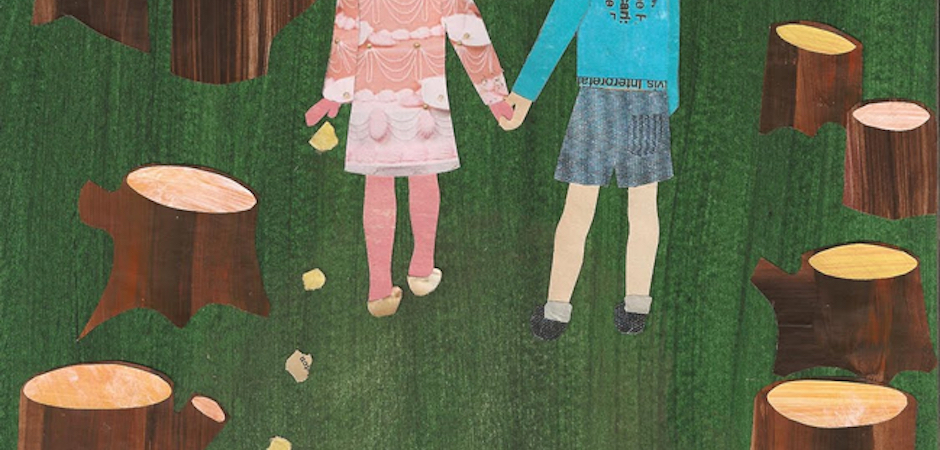

**c)** Your task is to transform the reward function from a sparse to a denser one by providing rewards as the agent progresses towards the end goal. You can utilize the provided reward wrapper skeleton below to implement this transformation. Keep in mind that this question is open-ended, allowing for multiple solutions. Feel free to be creative and experiment!

*tip: keep the very large reward when getting to the goal*

*tip: the location of the bolder is stored in `self.env.boulder`*

In [ ]:
class Dense_reward_Grid(gym.Wrapper):
    def __init__(self, env):
        super(Dense_reward_Grid, self).__init__(env)

    def step(self, action):
        goal_x, goal_y = self.Goal_loc
        dis_old = abs(self.env.boulder[0]-goal_x)+abs(self.env.boulder[1]-goal_y) #c)
        observation, reward, terminated, truncated, info = self.env.step(action)
        player_x, player_y, boulder_x, boulder_y = observation
        
        # this solution gives a reward each time the agent pushes the boulder closer to the end goal #c)
        # and a large negative reward when pushing the boulder against the wall (getting it stuck) #c)
        if boulder_x==goal_x and boulder_y==goal_y: #c)
            reward_new = 10000 #c)
        elif boulder_x==1 or boulder_y==1 or boulder_x==env.unwrapped.grid.shape[0]-2 or boulder_y==env.unwrapped.grid.shape[1]-2: #c)
            reward_new = -100 #c)
        else: #c)
            dis_new =  abs(self.env.boulder[0]-goal_x)+abs(self.env.boulder[1]-goal_y) #c)
            reward_new = 5*(dis_old-dis_new) #c)
        return observation, reward_new, terminated, truncated, info

max_episode_steps = 400
def env_con_new():
    env = Grid_world_boulder()
    env = wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)
    env = Dense_reward_Grid(env)
    #and reward wrapper
    return env

new_results = []
for z in range(10):
    Qmat, ep_lengths_steps, ep_lengths = Qlearn(env_con_new,nsteps=500_000)
    new_results.append((ep_lengths_steps, ep_lengths))
    plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=max_episode_steps),'b')
plt.ylabel('mean episode length')
plt.xlabel('steps')
plt.show()

In [ ]:
for results, c, name in [(base_results,'r', 'sparse rewards'),(new_results,'b','your dense rewards')]:

    for i,(ep_lengths_steps, ep_lengths) in enumerate(results):
        if i==0:
            plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=max_episode_steps),color=c,label=name)
        else:
            plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=max_episode_steps),color=c)
plt.legend()
plt.show()

## (Optional) Exercise 6: Multi Goals RL

In many control scenarios, having a stationary goal isn't always the case. For instance, in reference tracking tasks, the goal may change dynamically over time.
A simple way to accommodate non-static goals in an environment is to include the current goal or task as part of the state representation.

Here, we'll work with a grid world where the goal moves randomly throughout the grid.

**a)** Append the state with the goal location by editing the `get_obs` function and run the Q learning function.

*tip: player location is is `self.p` and goal location is `self.Goal_loc` (returns as tuples as normal).*

In [ ]:
def argmax(a):
    #random argmax
    a = np.array(a)
    return np.random.choice(np.arange(len(a),dtype=int)[a==np.max(a)])
import gymnasium as gym
from gymnasium import spaces
from gymnasium import wrappers
import numpy as np
from matplotlib import pyplot as plt
from gymnasium.wrappers import TimeLimit

class Grid_world_moving_goal(gym.Env):
    
    ######
    # +--------> y (second dim)
    # |
    # |
    # v
    # x (first dim)
    #
    # u=0 -> x+
    # u=1 -> y+
    # u=2 -> x-
    # u=3 -> y-
    def __init__(self, render_mode='human'):
        
        self.action_space = spaces.Discrete(5) #u = 0, 1, ..., P-1
        self.Goal = 2
        G = self.Goal
        self.Wall = -1
        W = self.Wall
        self.grid = [
                     [W,W,W,W,W,W,W,W,W,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,0,0,0,0,0,0,0,0,W],
                     [W,W,W,W,W,W,W,W,W,W],
                    ]
        self.grid = np.array(self.grid,dtype=int)
        self.observation_space = spaces.MultiDiscrete(self.grid.shape)
        self.reset()
        self.render_mode = render_mode
        
    
    def move_goal(self):
        from random import choice
        self.Goal_loc = list(choice(np.array(np.where(self.grid==0)).T))
    
    def reset(self):
        while True: #pick a random open location
            self.p = [np.random.randint(low=0,high=self.grid.shape[0]),np.random.randint(low=0,high=self.grid.shape[1])]
            if self.grid[self.p[0],self.p[1]]==0:
                break
        self.move_goal()
        return self.get_obs(), {}
    
    def get_obs(self):
        return tuple(self.p)+tuple(self.Goal_loc) #a)
    
    def step(self, u):
        ########
        #  2
        #  ^
        #3<4>1
        #  v
        #  0
        self.p_old = self.p[:]
        if u==0:
            self.p[0] += 1
        elif u==1:
            self.p[1] += 1
        elif u==2:
            self.p[0] -= 1
        elif u==3:
            self.p[1] -= 1
        
        if np.random.uniform()<1/50:
            self.move_goal()
        
        terminated = truncated = False
        end_loc = self.grid[self.p[0],self.p[1]]
        if end_loc == self.Wall: #player in wall
            self.p = self.p_old
            reward = -1
        if self.p == self.Goal_loc:
            reward = 1
        else:
            reward = 0
        return self.get_obs(), reward, terminated, truncated, {}
    
    def render(self, mode='human', Qmat=None):
        for x in range(self.grid.shape[0]):
            for y in range(self.grid.shape[1]):
                el = self.grid[x,y]
                if x==self.p[0] and y==self.p[1]:
                    print('P',end='')
                elif x==self.Goal_loc[0] and y==self.Goal_loc[1]:
                    print('G',end='')
                elif el==self.Wall:
                    print('#',end='')
                elif Qmat is None:
                    print(' ',end='')
                else:#← ↑ → ↓
                    abest = argmax([Qmat[(x, y, self.Goal_loc[0], self.Goal_loc[1]),a] for a in range(4)])
                    print('↓→↑←'[abest],end='')
            print() 

def Qlearn(env_con, nsteps=5000, callbackfeq=100, alpha=0.2,eps=0.2, gamma=0.99, callback=None):
    from collections import defaultdict
    Qmat = defaultdict(float) #any new argument is set to zero only when needed
    env = env_con()
    env_time = env
    while not isinstance(env_time,wrappers.time_limit.TimeLimit):
        env_time = env_time.env
    ep_rewards = []
    ep_lengths_steps = []
    c = 0
    
    obs, info = env.reset()
    reward_acc = 0
    print('rewards obtained:')
    for z in range(nsteps):

        if np.random.uniform()<eps:
            action = env.action_space.sample()
        else:
            action = argmax([Qmat[obs,i] for i in range(env.action_space.n)])

        obs_new, reward, terminated, truncated, info = env.step(action)
        reward_acc += reward

        if terminated:
            #printing
            print(reward_acc, end=' ')
            ep_rewards.append(reward_acc)
            ep_lengths_steps.append(z)
            reward_acc = 0
            

            A = reward - Qmat[obs,action] # adventage
            Qmat[obs,action] += alpha*A
            obs, info = env.reset()

        else:
            A = reward + gamma*max(Qmat[obs_new, action_next] for action_next in range(env.action_space.n)) - Qmat[obs,action]
            Qmat[obs,action] += alpha*A
            obs = obs_new
            if truncated: 
                print(reward_acc, end=' ')
                ep_rewards.append(reward_acc)
                ep_lengths_steps.append(z)
                reward_acc = 0
                obs, info = env.reset()
    print()
    return Qmat, np.array(ep_lengths_steps), np.array(ep_rewards)

In [ ]:
env = Grid_world_moving_goal()
env = TimeLimit(env,max_episode_steps=1000)
Qmat, steps, rewards = Qlearn(lambda: env, nsteps=100000)
plt.plot(steps,rewards)
plt.show()
env.unwrapped.render(Qmat=Qmat)